##  **🧬 Projeto de BI**: Painel de Indicadores de Testes Moleculares e não automatizado

Fase de Modelagem

Datasets e diciononário de dados extraídos do repositório Kaggle: https://www.kaggle.com/datasets/marciosaraiva/covid19-data-sharing-br-einstein-hospital



In [1]:
#Imports necessários para o projeto

import pandas as pd
import numpy as np
from faker import Faker
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


## Análise Exploratória 

In [2]:
# Dataset com as informações dos exames
df1= pd.read_csv("einstein_small_dataset_exames.csv", sep='|')

In [3]:
# Dataset com as informações dos pacientes
df2= pd.read_csv("einstein_small_dataset_paciente1.csv", sep='|')

In [4]:
df1.head()

,id_paciente,dt_coleta,de_origem,de_exame,de_analito,de_resultado,cd_unidade,de_valor_referencia
0,202018,13/06/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado
1,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgG, COVID19",0.07,AU/ml,<=0.90
2,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,COVID IgG Interp,Não reagente,NaN,NaN
3,202025,11/05/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado
4,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgM, COVID19",0.33,AU/ml,<=0.90


In [5]:
df2.head()

,id_paciente,ic_sexo,aa_nascimento,cd_pais,cd_uf,cd_municipio,cd_distrito
0,204591,M,1954,BR,SP,SAO PAULO,NaN
1,204990,F,1954,BR,SP,SAO PAULO,NaN
2,204653,F,1956,BR,SP,SAO PAULO,NaN
3,202577,F,1957,BR,SP,SAO PAULO,NaN
4,206125,M,1957,BR,SP,SAO PAULO,NaN


In [30]:
df1.isnull().sum()

id_paciente              0
dt_coleta                0
de_origem                0
de_exame                 0
de_analito               0
de_resultado             0
cd_unidade             566
de_valor_referencia    422
falha_tecnica            0
dtype: int64

### KPI 1 •	Taxa de recoleta (Nova Coleta) 

In [12]:
df1['de_resultado'].unique()

array(['Não detectado', '0.07', 'Não reagente', '0.33', '4.95', '253',
       '9.6', '30.3', '78', '8.5', '43.7', '3055', '6500', '88.3', '42.5',
       '2762', '0.8', '52', '13.0', '552', '15.0', '47.0', '1.2', '6.50',
       '34.3', '7530', '22', ' ', '4247', '38', '10.1', '4.4', '86.7',
       '2.3', '240.00', '7.53', '843', '173', '4.66', '36', '34.4', '10',
       '13.9', '12.1', '79', '40.4', '11.2', '4.6', '1.15', '58', '56.4',
       '0.5', '29.6', '29.8', '140', '85', '33.1', '1.11', '1.6', '1.17',
       '233', '391', '19', '2229', '1932', '263', '11640', '38.4', '11.4',
       '8695', '26', '6.7', '16.6', '163', '0.6', '11.64', '32.2', '36.5',
       '4.35', '1.4', '12.2', '14.0', '780', '74.7', '70', '0.32', '1.12',
       'Detectado', '0.65', '0.94', '0.38', '0.62', '0.08', '0.50', '0.4',
       'Ausente', '5.0', '32', 'Ausentes', '167', '21', '0.93', '4170',
       '359', '1868', 'Amarela', 'Negativo', '51', '44.8', 'Normal',
       '4.44', 'Não Detectado', '24', '4.17', 

In [13]:
# garantir que a data está em datetime
df1['dt_coleta'] = pd.to_datetime(df1['dt_coleta'], dayfirst=True)

In [20]:
valores_falha = [
    'NOVA COLETA',
  
]

df1['falha_tecnica'] = df1['de_resultado'].isin(valores_falha)

In [21]:
df1 = df1.sort_values(['id_paciente', 'dt_coleta'])

In [22]:
resumo_paciente = (
    df1
    .groupby('id_paciente')
    .agg(
        n_exames=('id_paciente', 'size'),
        n_falhas=('falha_tecnica', 'sum'),
        teve_falha=('falha_tecnica', 'any'),
        primeira_coleta=('dt_coleta', 'min'),
        ultima_coleta=('dt_coleta', 'max')
    )
)

# Paciente com "retorno pós falha" = tem pelo menos 1 falha e mais de 1 exame
resumo_paciente['teve_retorno_pos_falha'] = (
    (resumo_paciente['n_falhas'] >= 1) &
    (resumo_paciente['n_exames'] > 1)
)

resumo_paciente.head()

,n_exames,n_falhas,teve_falha,primeira_coleta,ultima_coleta,teve_retorno_pos_falha
id_paciente,,,,,,
202018,1,0,False,2020-06-13,2020-06-13,False
202025,26,0,False,2020-05-11,2020-05-19,False
202078,1,0,False,2020-03-24,2020-03-24,False
202107,1,0,False,2020-04-30,2020-04-30,False
202133,44,0,False,2020-05-29,2020-05-29,False


In [23]:
ids_com_retorno = resumo_paciente.query('teve_retorno_pos_falha').index

df_retorno = df1[df1['id_paciente'].isin(ids_com_retorno)].copy()
df_retorno = df_retorno.sort_values(['id_paciente', 'dt_coleta'])

df_retorno.head(20)

,id_paciente,dt_coleta,de_origem,de_exame,de_analito,de_resultado,cd_unidade,de_valor_referencia,falha_tecnica
1269,204038,2020-02-17,HOSP,Tempo de Protrombina,"TP, Atividade",89,%,70 a 100,False
1270,204038,2020-02-17,HOSP,Tempo de Protrombina,RNI,1.09,NaN,0.96 a 1.30,False
1271,204038,2020-02-17,HOSP,Hemograma com Plaquetas,CHCM,31.8,g/dL,31.0 a 36.0,False
1272,204038,2020-02-17,HOSP,Hemograma com Plaquetas,VCM,83.6,fL,81.0 a 95.0,False
1273,204038,2020-02-17,HOSP,Dosagem de CreatiNINA,Creatinina,2.25,mg/dL,0.70 a 1.20,False
1274,204038,2020-02-17,HOSP,Dosagem de Glicose,Dosagem de Glicose,161,mg/dL,70 a 99,False
1275,204038,2020-02-17,HOSP,Dosagem de Bilirrubina Total e Frações,Bilirrubina Indireta,0.0,mg/dL,0.1 a 0.9,False
1276,204038,2020-02-17,HOSP,Dosagem de Bilirrubina Total e Frações,Bilirrubina Direta,0.1,mg/dL,0.0 a 0.3,False
1277,204038,2020-02-17,HOSP,Hemograma Contagem Auto,Linfócitos,37.0,%,NaN,False
1278,204038,2020-02-17,HOSP,Dosagem de Sódio,Sódio,139,mEq/L,135 a 145,False


A partir do campo original de_resultado, foi realizada a identificação de exames cujo resultado corresponde a “NOVA COLETA”, indicando a necessidade de repetir o procedimento. Esse critério permite medir, de forma direta e sem criação de variáveis artificiais, a ocorrência de recoletas dentro do processo laboratorial. O KPI de recoleta foi calculado como a proporção de pacientes que apresentaram ao menos um exame com esse resultado em relação ao total de pacientes únicos registrados no dataset. Essa métrica é fundamental para avaliar a qualidade operacional, pois recoletas representam retrabalho, aumento de custos, atraso na liberação de resultados e potenciais inconsistências no processo de coleta ou processamento das amostras. Além disso, o indicador reforça evidências levantadas na Fase 1 sobre falhas de registro, necessidade de padronização e baixa governança dos dados clínicos

### KPI 2 •	Reincidência de Pacientes (Pacientes com >1 exame)

In [60]:
reincidentes = exames_por_paciente[exames_por_paciente['qtde_exames'] > 1]
print(reincidentes)

     id_paciente  qtde_exames
1         202025           26
4         202133           44
6         202251           23
8         202281            7
9         202285            2
10        202327            2
11        202331            5
15        202598           86
17        202732           65
18        202771            3
20        202874           19
21        202878            3
22        202889           26
23        203014           51
26        203109            5
27        203113           87
28        203215           77
30        203249           96
31        203295           79
32        203317            2
34        203473            5
35        203554           85
37        203629           45
38        203635            5
41        203988          350
45        204038          211
50        204210            3
54        204549            2
55        204591           58
58        204775           49
61        204944            8
64        205170           23
67        

In [61]:
total_pacientes = exames_por_paciente['id_paciente'].nunique()
print(total_pacientes)

103


In [34]:
reincidentes_sorted = (
    df1[df1['id_paciente'].isin(reincidentes['id_paciente'])]
    .sort_values(['id_paciente', 'dt_coleta'])
)

reincidentes_sorted.head(20)

,id_paciente,dt_coleta,de_origem,de_exame,de_analito,de_resultado,cd_unidade,de_valor_referencia,falha_tecnica
1,202025,2020-05-11,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgG, COVID19",0.07,AU/ml,<=0.90,False
2,202025,2020-05-11,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,COVID IgG Interp,Não reagente,NaN,NaN,False
3,202025,2020-05-11,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado,False
4,202025,2020-05-11,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgM, COVID19",0.33,AU/ml,<=0.90,False
5,202025,2020-05-11,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,COVID IgM Interp,Não reagente,NaN,NaN,False
6,202025,2020-05-19,HOSP,Hemograma com Plaquetas,Hemácias,4.95,x10^6/uL,4.30 a 5.70,False
7,202025,2020-05-19,HOSP,Hemograma com Plaquetas,Plaquetas,253,x10^3/uL,NaN,False
8,202025,2020-05-19,HOSP,Hemograma com Plaquetas,Volume Médio Plaquetário,9.6,fL,6.5 a 15.0,False
9,202025,2020-05-19,HOSP,Hemograma com Plaquetas,HCM,30.3,pg,26.0 a 34.0,False
10,202025,2020-05-19,HOSP,Hemograma Contagem Auto,Eosinófilos #,78,µL,50 a 500,False


In [37]:
df1['dt_coleta'] = pd.to_datetime(df1['dt_coleta'], dayfirst=True, errors='coerce')


In [38]:
df1 = df1.sort_values(['id_paciente', 'dt_coleta'])

In [39]:
df1['data_anterior'] = df1.groupby('id_paciente')['dt_coleta'].shift(1)

# diferença entre datas
df1['dias_desde_exame_anterior'] = (
    df1['dt_coleta'] - df1['data_anterior']
).dt.days

# reincidência dentro de 30 dias
df_reincidencia_30d = df1[
    (df1['dias_desde_exame_anterior'] > 0) &
    (df1['dias_desde_exame_anterior'] <= 30)
]

In [40]:
total_pacientes = df1['id_paciente'].nunique()

pacientes_reincidentes_30d = df_reincidencia_30d['id_paciente'].nunique()

kpi_reincidencia_30d = (pacientes_reincidentes_30d / total_pacientes) * 100

print("Total de pacientes:", total_pacientes)
print("Pacientes com retorno em até 30 dias:", pacientes_reincidentes_30d)
print(f"KPI de Reincidência em 30 dias: {kpi_reincidencia_30d:.2f}%")


Total de pacientes: 103
Pacientes com retorno em até 30 dias: 27
KPI de Reincidência em 30 dias: 26.21%


A partir das datas originais de coleta (dt_coleta), foi analisado o intervalo entre exames sucessivos de cada paciente. Pacientes que realizaram um novo exame dentro de até 30 dias após o exame anterior foram classificados como reincidentes dentro do período mensal. Essa abordagem utiliza exclusivamente as colunas originais do dataset e permite identificar retornos clínicos ou operacionais em curto prazo, fornecendo um indicador importante para avaliar retrabalho, qualidade dos processos e consistência do atendimento laboratorial.

### KPI 3  •	Distribuição e Padronização de Resultados


In [41]:
distribuicao_resultados = df1['de_resultado'].value_counts(dropna=False)

print(distribuicao_resultados)

Não detectado    240
Ausentes          58
0.0               46
0                 43
Não reagente      37
                ... 
28.4               1
2814               1
244                1
4620               1
0.79               1
Name: de_resultado, Length: 908, dtype: int64


In [42]:
num_categorias = df1['de_resultado'].nunique()
print("Categorias distintas:", num_categorias)

Categorias distintas: 908


In [43]:
categorias_raras = distribuicao_resultados[distribuicao_resultados == 1]
print(categorias_raras)

37.0     1
22.6     1
6.23     1
341      1
7.212    1
        ..
28.4     1
2814     1
244      1
4620     1
0.79     1
Name: de_resultado, Length: 608, dtype: int64


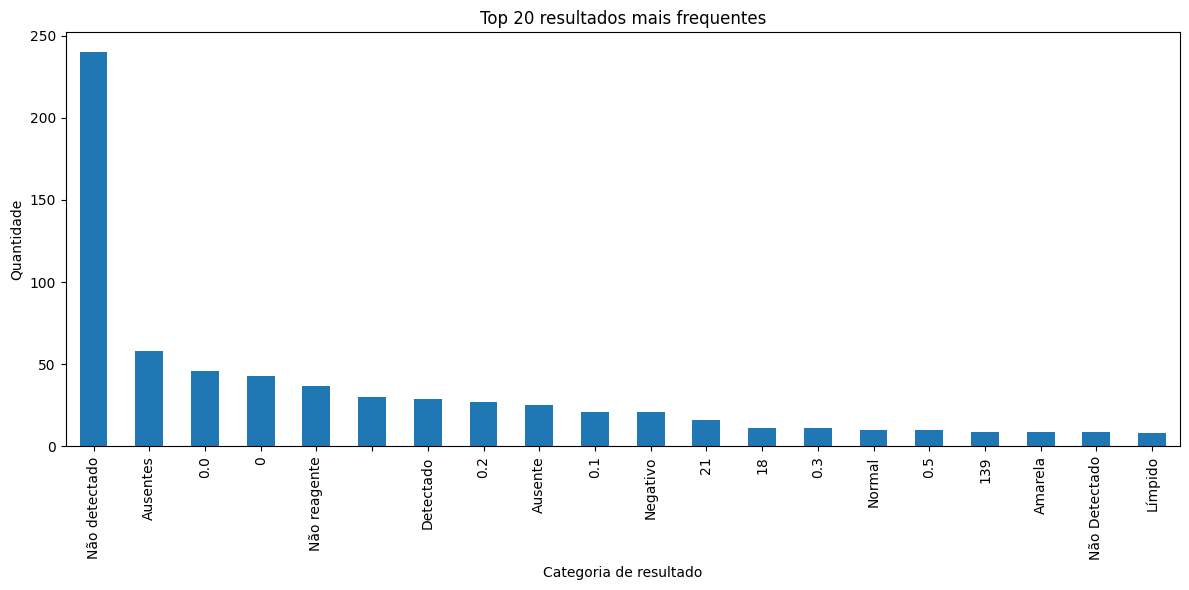

In [46]:
top20 = distribuicao_resultados.head(20)

plt.figure(figsize=(12, 6))
top20.plot(kind='bar')
plt.title("Top 20 resultados mais frequentes")
plt.xlabel("Categoria de resultado")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

A distribuição dos resultados foi analisada diretamente a partir da coluna original de_resultado. Observou-se a existência de centenas de categorias distintas, incluindo valores numéricos e categorias extremamente raras, sugerindo baixa padronização e falhas no processo de registro. Por meio da contagem de frequências, identificação de categorias anômalas e separação entre valores textuais e numéricos, tornou-se evidente a presença de ruído, erros de digitação e inconsistências na governança de dados. 

### KPI 4  	•	Volume de Exames por Período


In [47]:
df1['dt_coleta'] = pd.to_datetime(df1['dt_coleta'], dayfirst=True, errors='coerce')


In [48]:
volume_mensal = (
    df1
    .groupby(df1['dt_coleta'].dt.to_period('M'))
    .size()
    .reset_index(name='qtde_exames')
)

volume_mensal.head()

,dt_coleta,qtde_exames
0,2020-01,227
1,2020-02,129
2,2020-03,409
3,2020-04,529
4,2020-05,565


O volume de exames por período foi calculado a partir da coluna original dt_coleta, convertida para o formato de data e utilizada para agrupar os registros mensalmente, diariamente e semanalmente. Essa abordagem permite analisar a evolução da demanda ao longo do tempo sem a necessidade de criar colunas adicionais ou realizar transformações irreversíveis nos dados. Esse KPI é fundamental para apoiar decisões de planejamento, alocação de recursos e monitoramento de tendências clínicas e operacionais.

### KPI 5 	•	Volume por Tipo de Exame


In [50]:
volume_por_tipo = (
    df1['de_exame']
    .value_counts()
    .reset_index(name='qtde_exames')
)

volume_por_tipo.rename(columns={'index': 'tipo_exame'}, inplace=True)

volume_por_tipo.head()

,tipo_exame,qtde_exames
0,Hemograma com Plaquetas,473
1,Hemograma Contagem Auto,360
2,Urina Tipo I,180
3,Painel Molecular Patogenos Respiratorios,144
4,Diferencial Manual,140


O volume por tipo de exame foi calculado diretamente a partir da coluna original de_exame, utilizando a contagem de ocorrências de cada categoria presente no dataset. Esse indicador permite identificar quais exames moleculares e sorológicos são mais realizados, oferecendo subsídios essenciais para o planejamento de recursos, previsão de insumos e análise epidemiológica. 


## 🔎Análise preditiva: previsão de volume de exames

Usado Regressão Linear para análise


In [53]:

df1['dt_coleta'] = pd.to_datetime(df1['dt_coleta'], dayfirst=True)

# agrupar por mês
volume_mensal = (
    df1
      .groupby(df1['dt_coleta'].dt.to_period('M'))
      .size()
      .reset_index(name='qtde_exames')
)

# converter Period -> datetime
volume_mensal['dt_coleta'] = volume_mensal['dt_coleta'].dt.to_timestamp()
volume_mensal.head()

,dt_coleta,qtde_exames
0,2020-01-01,227
1,2020-02-01,129
2,2020-03-01,409
3,2020-04-01,529
4,2020-05-01,565


In [54]:
from sklearn.linear_model import LinearRegression
import numpy as np

# criar índice temporal
volume_mensal['time_index'] = np.arange(len(volume_mensal))

X = volume_mensal[['time_index']]
y = volume_mensal['qtde_exames']

modelo = LinearRegression()
modelo.fit(X, y)

# prever mais 3 meses
future = pd.DataFrame({'time_index': np.arange(len(volume_mensal), len(volume_mensal)+3)})
previsoes = modelo.predict(future)

print("Previsão para os próximos 3 meses:", previsoes)


Previsão para os próximos 3 meses: [477.8        515.88571429 553.97142857]


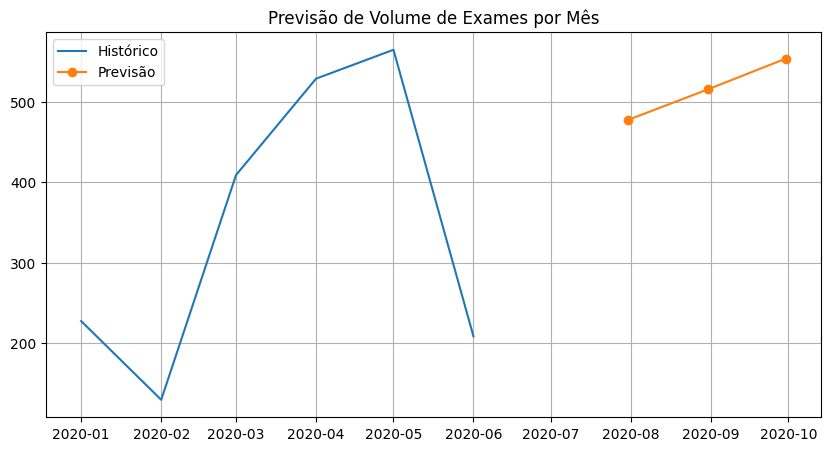

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(volume_mensal['dt_coleta'], y, label="Histórico")
plt.plot(pd.date_range(volume_mensal['dt_coleta'].iloc[-1], periods=4, freq='M')[1:], 
         previsoes, label="Previsão", marker='o')

plt.title("Previsão de Volume de Exames por Mês")
plt.legend()
plt.grid(True)
plt.show()


### Interpretação

Tendência é crescente → sugere que o o laboratório precisa mais capacidade, reagentes, pessoal.

## 🔎Análise preditiva: Previsão de Reincidência de Pacientes (Retorno em 30 dias)

In [57]:
# ordenar dados por paciente e data
df1 = df1.sort_values(['id_paciente', 'dt_coleta'])

# data anterior do mesmo paciente
df1['data_anterior'] = df1.groupby('id_paciente')['dt_coleta'].shift(1)

# diferença em dias
df1['dias_retorno'] = (df1['dt_coleta'] - df1['data_anterior']).dt.days

# apenas retornos em até 30 dias
retornos_30d = df1[(df1['dias_retorno'] > 0) & (df1['dias_retorno'] <= 30)]

# calcular reincidência mensal
reincidencia_mensal = (
    retornos_30d
    .groupby(retornos_30d['dt_coleta'].dt.to_period('M'))
    .size()
    .reset_index(name='retornos_30d')
)

reincidencia_mensal['dt_coleta'] = reincidencia_mensal['dt_coleta'].dt.to_timestamp()
reincidencia_mensal.head()


,dt_coleta,retornos_30d
0,2020-01-01,2
1,2020-02-01,1
2,2020-03-01,3
3,2020-04-01,25
4,2020-05-01,12


In [58]:
# modelo temporal
reincidencia_mensal['time_index'] = np.arange(len(reincidencia_mensal))

X = reincidencia_mensal[['time_index']]
y = reincidencia_mensal['retornos_30d']

modelo2 = LinearRegression()
modelo2.fit(X, y)

# previsão de retornos para próximos 3 meses
future2 = pd.DataFrame({'time_index': np.arange(len(reincidencia_mensal), len(reincidencia_mensal)+3)})
previsoes2 = modelo2.predict(future2)

print("Previsão de reincidência para 30 dias:", previsoes2)


Previsão de reincidência para 30 dias: [17.66666667 20.23809524 22.80952381]


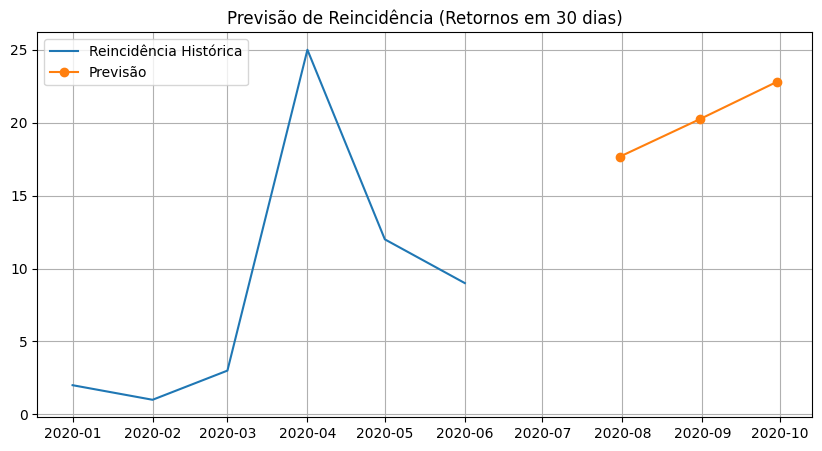

In [59]:
plt.figure(figsize=(10,5))
plt.plot(reincidencia_mensal['dt_coleta'], y, label="Reincidência Histórica")
plt.plot(pd.date_range(reincidencia_mensal['dt_coleta'].iloc[-1], periods=4, freq='M')[1:], 
         previsoes2, label="Previsão", marker='o')

plt.title("Previsão de Reincidência (Retornos em 30 dias)")
plt.legend()
plt.grid(True)
plt.show()


### Interpretação

Crescimento no retorno de pacientes → sugere falhas crescentes no fluxo laboratorial.

### Conclusão





De forma geral, os KPIs calculados e as análises preditivas esclarecem o comportamento dos exames ao longo do tempo e evidenciam oportunidades de melhoria na padronização, na eficiência operacional e na tomada de decisão baseada em dados. Esses insights fortalecem o papel do BI no suporte à gestão laboratorial e na evolução dos processos analisados.